In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC

folder = "../KOI_Data/sample/"

In [5]:
import os

fits_available = os.listdir(folder)
fits_available[:3]

['kplr001026957-20160128150956_dvt.fits',
 'kplr000892772-20160128150956_dvt.fits',
 'kplr002013883-20160128150956_dvt.fits']

In [18]:
a = fits.open(folder+fits_available[0])
b = fits.open(folder+fits_available[1])
c = fits.open(folder+fits_available[2])
print(len(a[1].data.field("LC_INIT")))
print(len(b[1].data.field("LC_INIT")))
print(len(c[1].data.field("LC_INIT")))

71427
71427
71427


In [6]:
hdulist = fits.open(folder+fits_available[4])

hdulist.info()

Filename: ../KOI_Data/sample/kplr001431122-20160128150956_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  TCE_1         1 BinTableHDU    106   71427R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    221   71427R x 50C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [7]:
hdulist[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   44 / length of first array dimension                
NAXIS2  =                71427 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [8]:
data = hdulist[1].data

time = data.field('TIME')
lc_init = data.field("LC_INIT")
lc_error = data.field("LC_INIT_ERR")
lc_white = data.field("LC_WHITE")
lc_detrend = data.field("LC_DETREND")
time

array([ 131.5126894 ,  131.53312411,  131.55355871, ..., 1590.96063093,
       1590.98106548, 1591.00150022])

In [9]:
#plot until
p_n = 1000

In [15]:
hdulist[1].data.field("LC_INIT")

array([-4.7542781e-04, -2.8195378e-04, -7.9507794e-05, ...,
       -1.8654378e-04,  6.1095980e-06,  3.3812580e-04], dtype=float32)

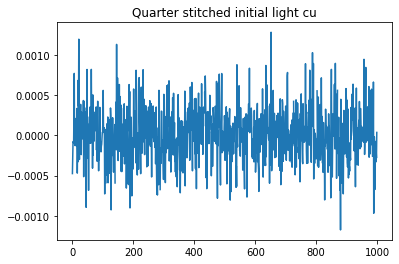

In [12]:
plt.plot(lc_init[:p_n])
plt.title("Quarter stitched initial light cu")
plt.show()

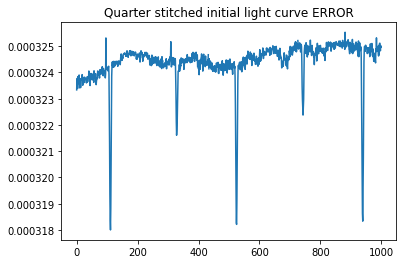

In [7]:
plt.plot(lc_error[:p_n])
plt.title("Quarter stitched initial light curve ERROR")
plt.show()

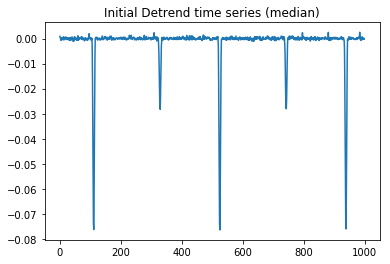

In [8]:
plt.plot(lc_detrend[:p_n])
plt.title("Initial Detrend time series (median)")
plt.show()

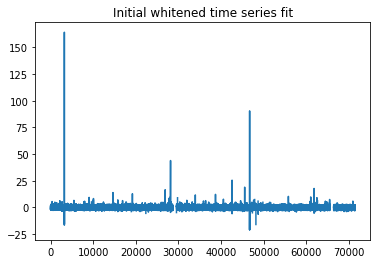

In [10]:
plt.plot(lc_white[:p_n])
plt.title("Initial whitened time series fit")
plt.show()

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Clean done (remove outliers iterativetly), erase 1 values


/home/fmena/Desktop/LC_process/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in less
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)
/home/fmena/Desktop/LC_process/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in greater
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)


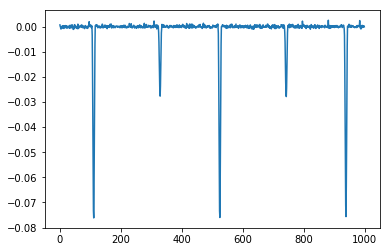

In [9]:
final_lc = clean_LC(lc_init, kernel_median=25, detrend_median=True) 
plt.plot(final_lc[:p_n])

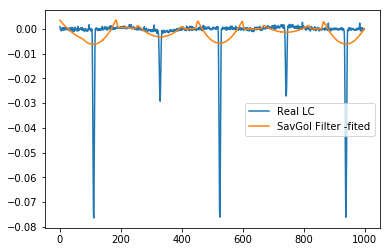

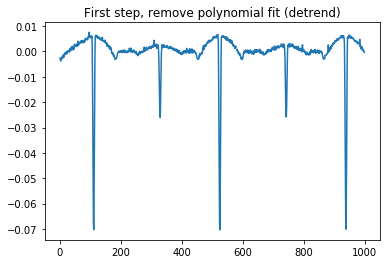

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Clean done (remove outliers iterativetly), erase 1 values


/home/fmena/Desktop/LC_process/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in less
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)
/home/fmena/Desktop/LC_process/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in greater
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)


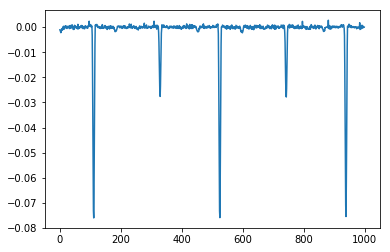

In [10]:
final_lc = clean_LC(lc_init, kernel_median=25, kernel_pol=151) 
plt.plot(final_lc[:p_n])

UNA CURVA DE LUZ


/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


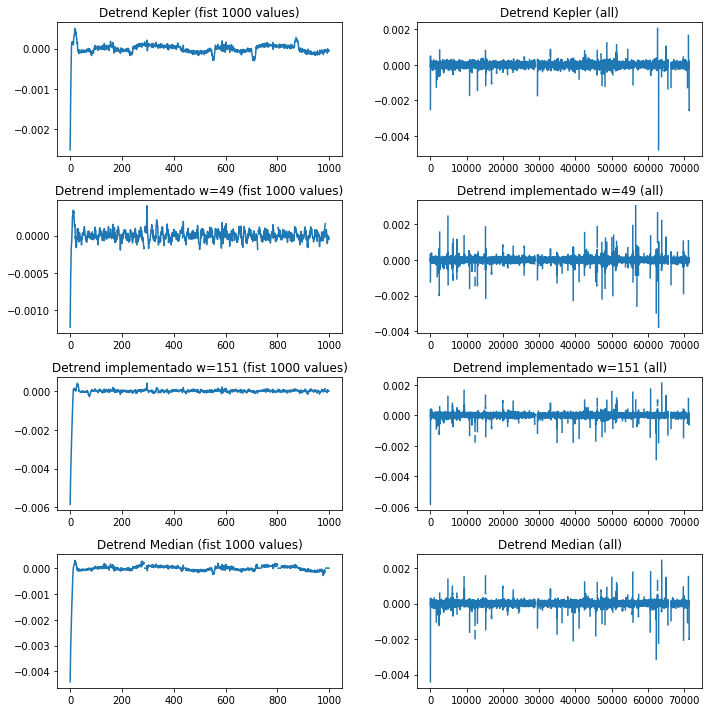

UNA CURVA DE LUZ


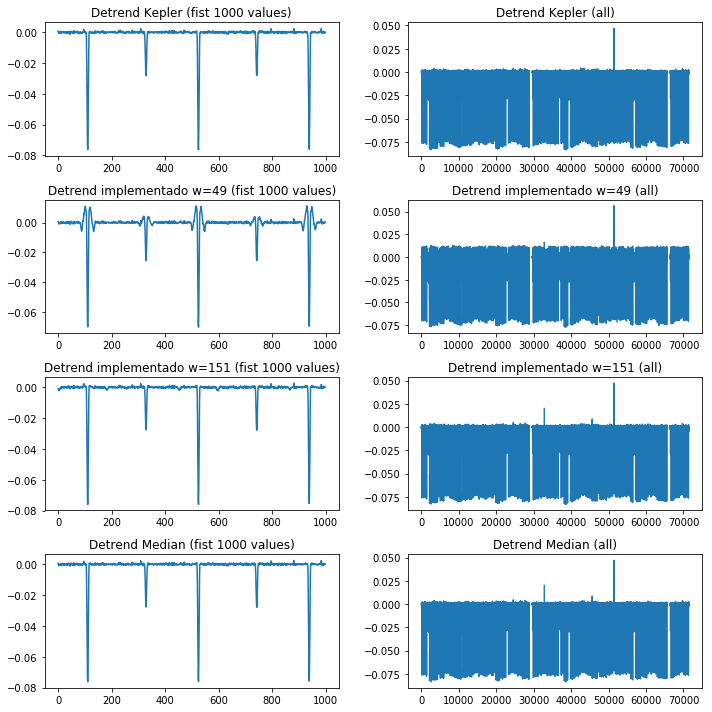

UNA CURVA DE LUZ


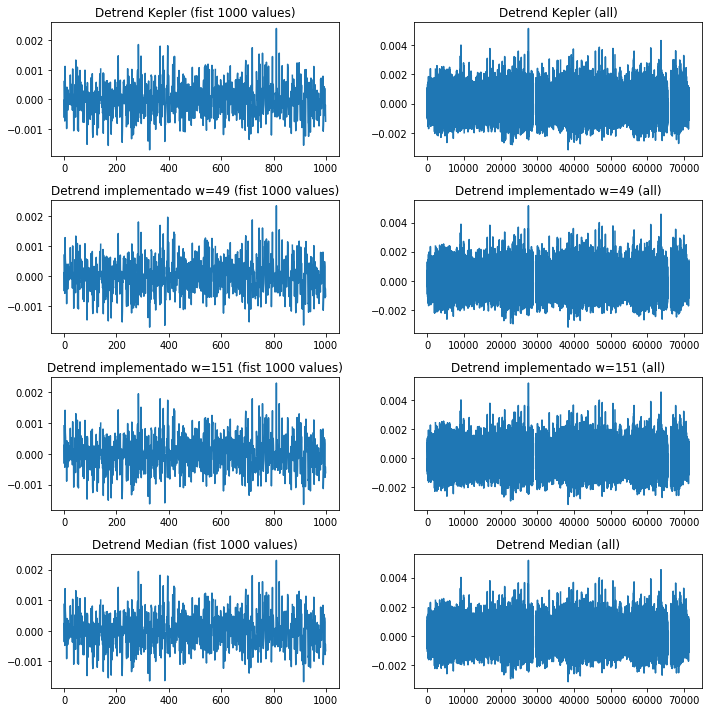

UNA CURVA DE LUZ


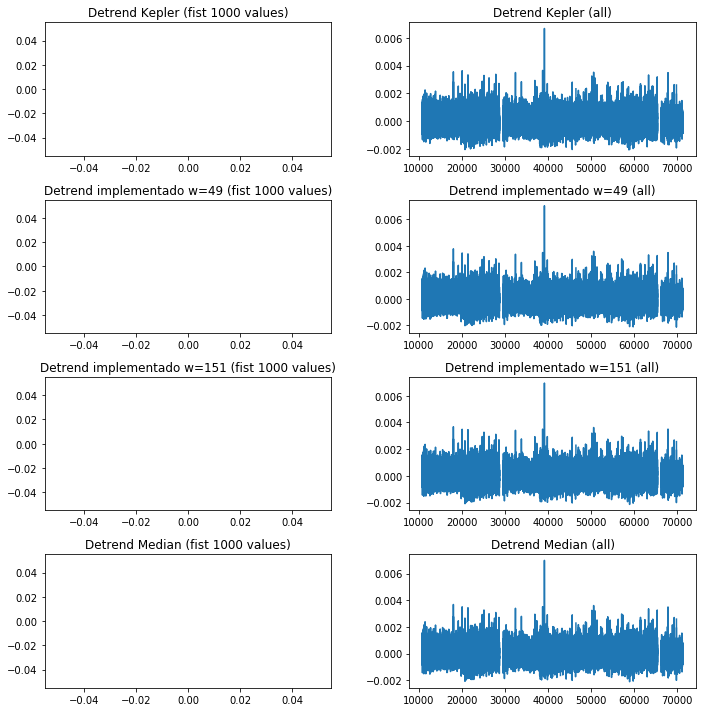

UNA CURVA DE LUZ


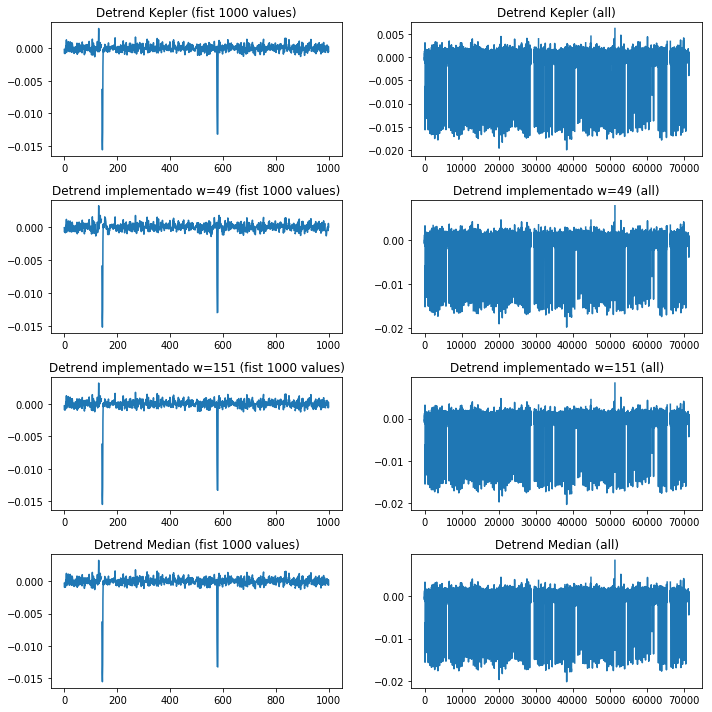

UNA CURVA DE LUZ


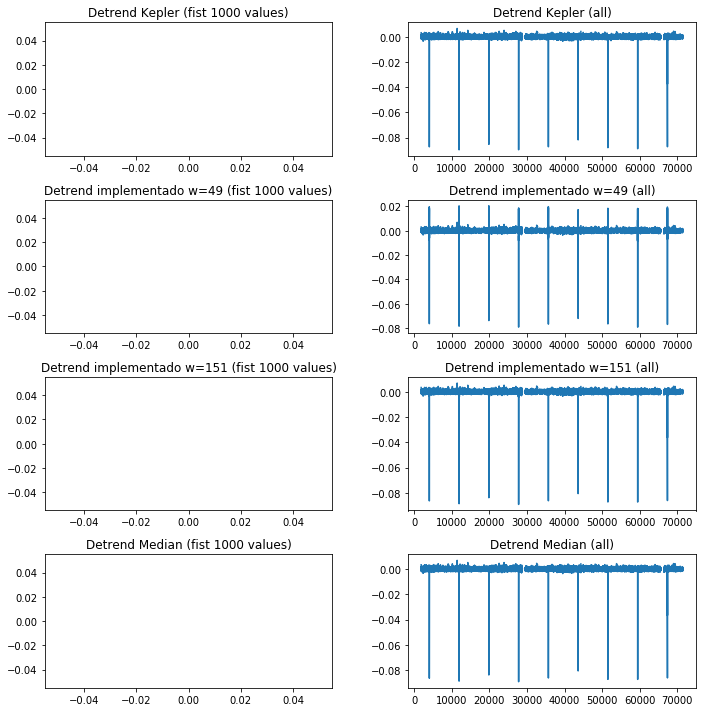

UNA CURVA DE LUZ


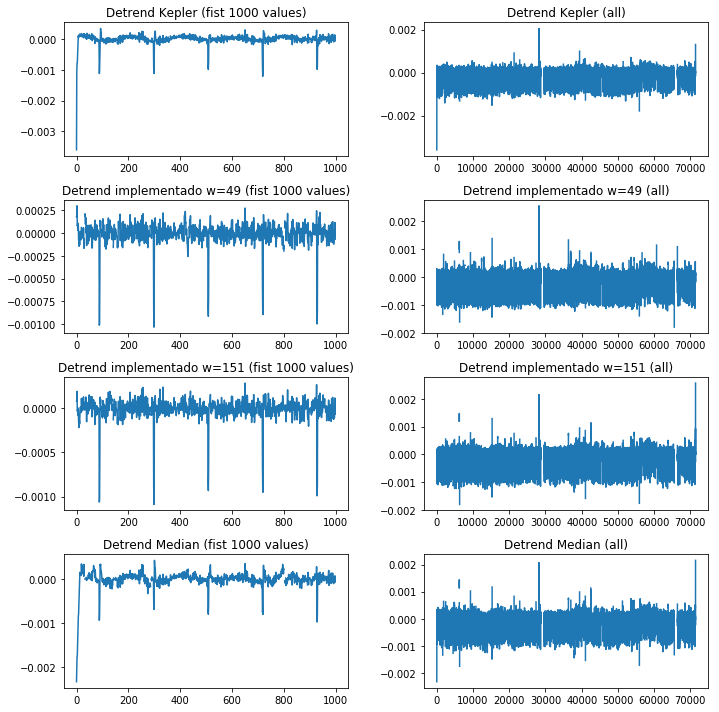

UNA CURVA DE LUZ


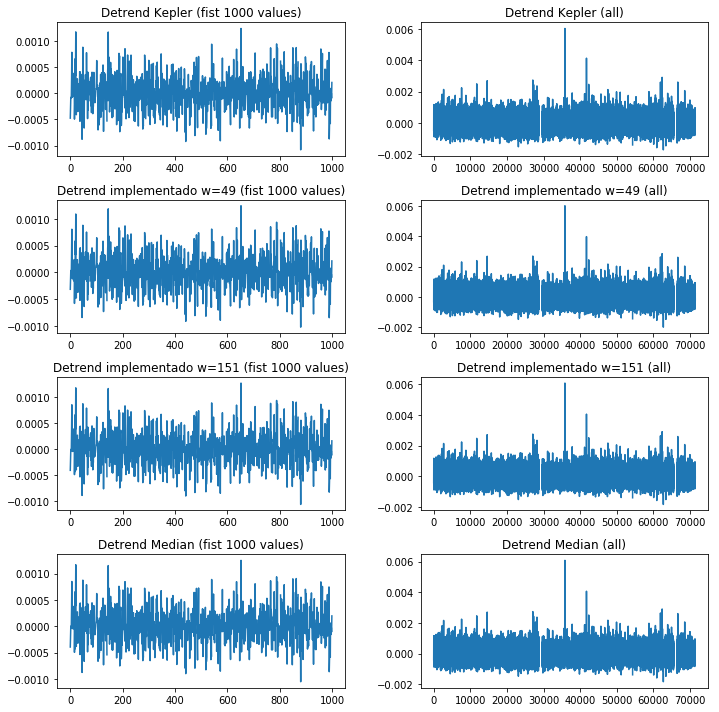

UNA CURVA DE LUZ


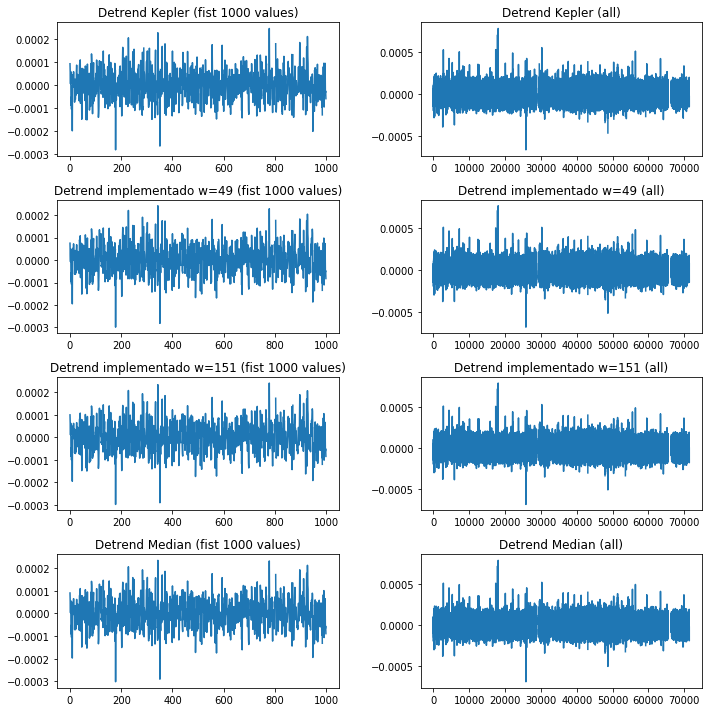

UNA CURVA DE LUZ


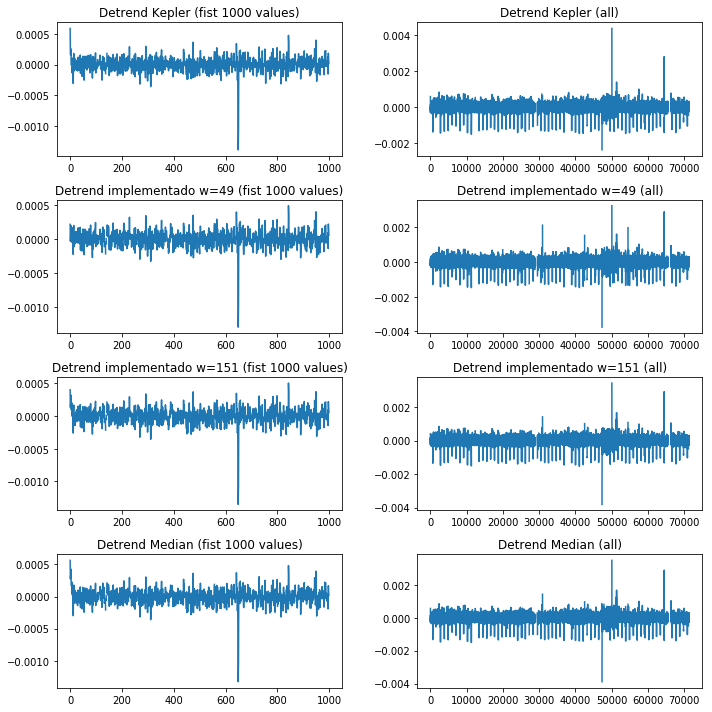

UNA CURVA DE LUZ


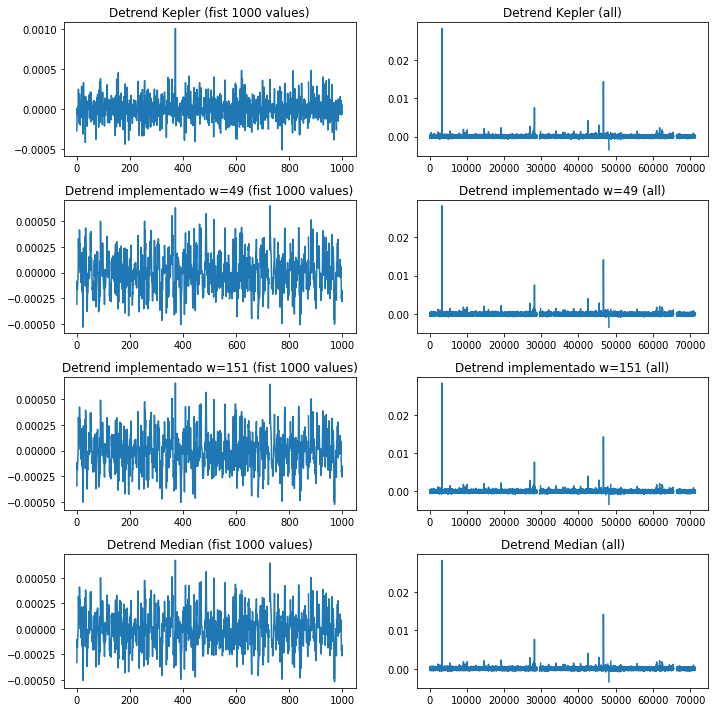

In [26]:
p_n = 1000
for i in range(len(fits_available)):
    print("UNA CURVA DE LUZ")
    hdulist = fits.open(folder+fits_available[i])
    data = hdulist[1].data
    lc_init = data.field("LC_INIT")
    lc_detrend = data.field("LC_DETREND")
    
    plt.figure(figsize=(10,10))    
    
    plt.subplot(4, 2, 1)
    plt.plot(lc_detrend[:p_n])
    plt.title("Detrend Kepler (fist 1000 values)")

    plt.subplot(4, 2, 2)
    plt.plot(lc_detrend)
    plt.title("Detrend Kepler (all)")

    final_lc = clean_LC(lc_init, kernel_median=25, kernel_pol=49, plot=False) 
    plt.subplot(4, 2, 3)
    plt.plot(final_lc[:p_n])
    plt.title("Detrend implementado w=49 (fist 1000 values)")

    plt.subplot(4, 2, 4)
    plt.plot(final_lc)
    plt.title("Detrend implementado w=49 (all)")
    
    final_lc = clean_LC(lc_init, kernel_median=25, kernel_pol=151, plot=False) 
    plt.subplot(4, 2, 5)
    plt.plot(final_lc[:p_n])
    plt.title("Detrend implementado w=151 (fist 1000 values)")

    plt.subplot(4, 2, 6)
    plt.plot(final_lc)
    plt.title("Detrend implementado w=151 (all)")
    
    final_lc = clean_LC(lc_init, kernel_median=25, detrend_median=True) 
    plt.subplot(4, 2, 7)
    plt.plot(final_lc[:p_n])
    plt.title("Detrend Median (fist 1000 values)")

    plt.subplot(4, 2, 8)
    plt.plot(final_lc)
    plt.title("Detrend Median (all)")

    plt.tight_layout()
    plt.show()

UNA CURVA DE LUZ


/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


Clean done (remove outliers iterativetly), erase 366 values
Clean done (remove outliers iterativetly), erase 152 values
Clean done (remove outliers iterativetly), erase 1359 values


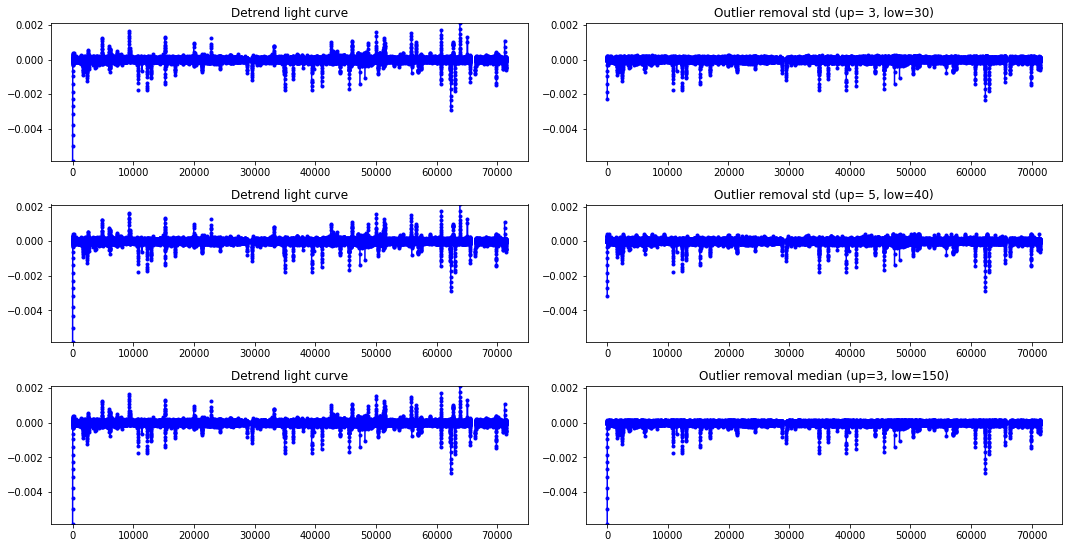

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 960 values


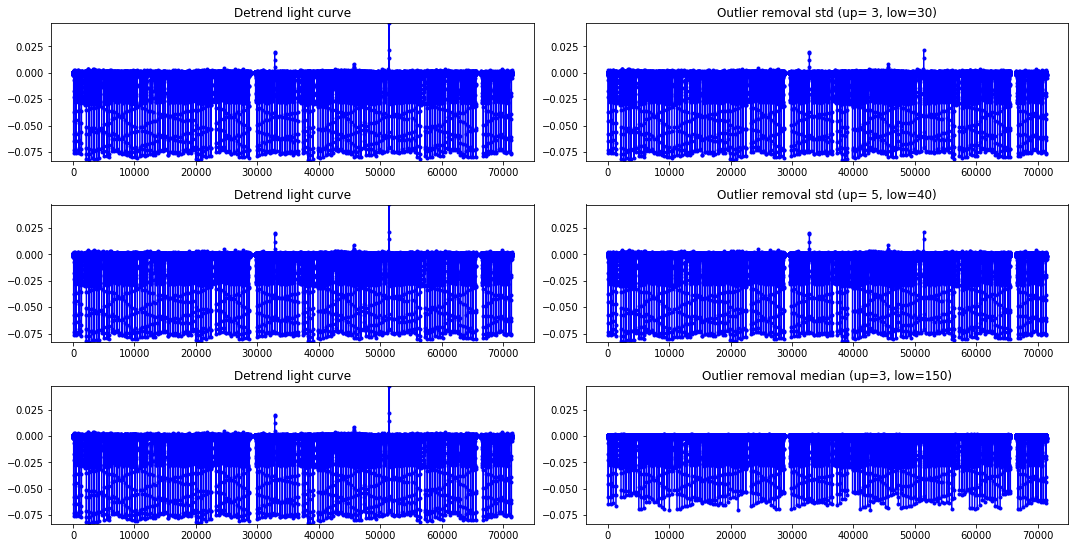

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 359 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 481 values


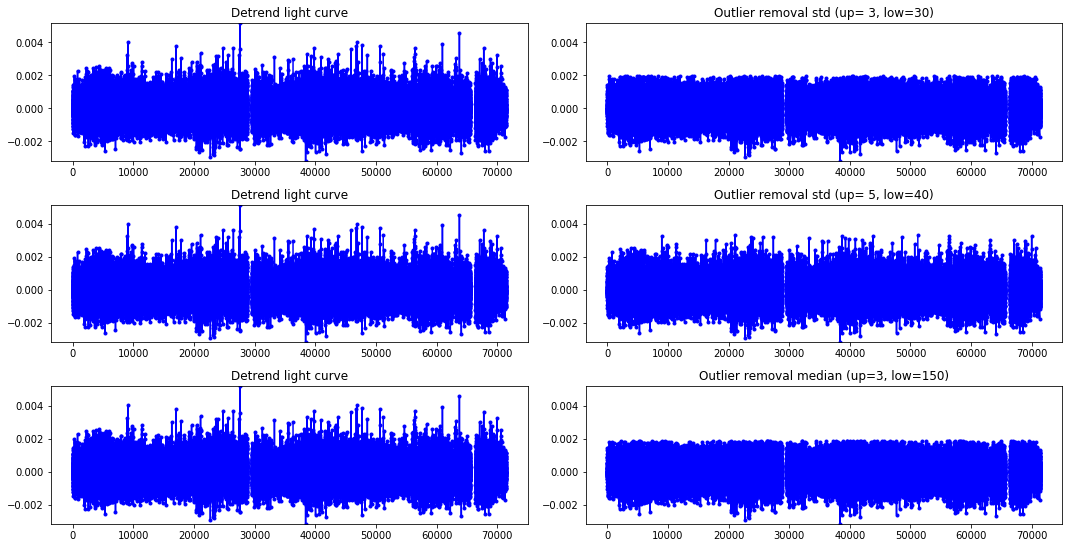

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 375 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 478 values


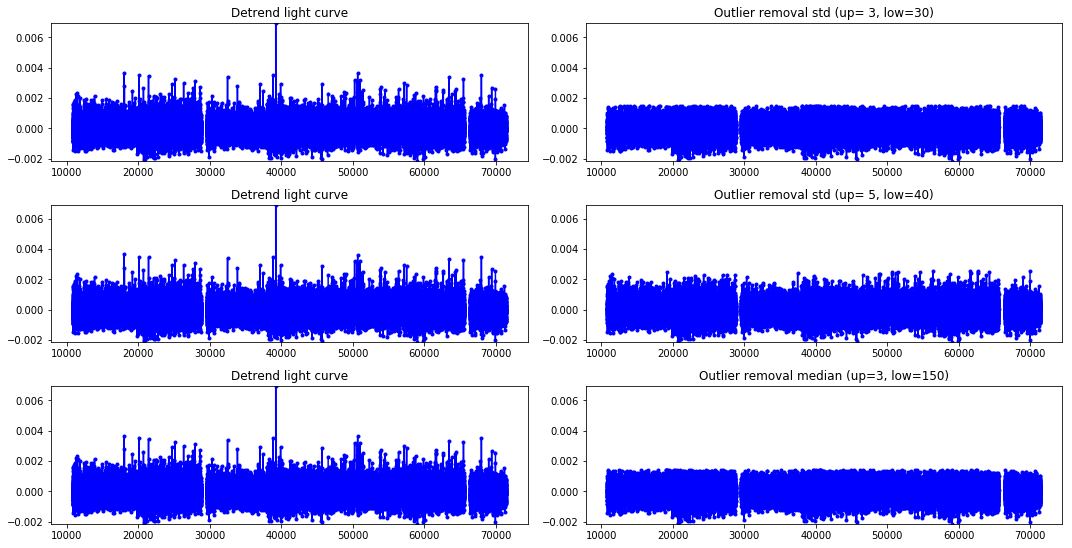

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 8 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 475 values


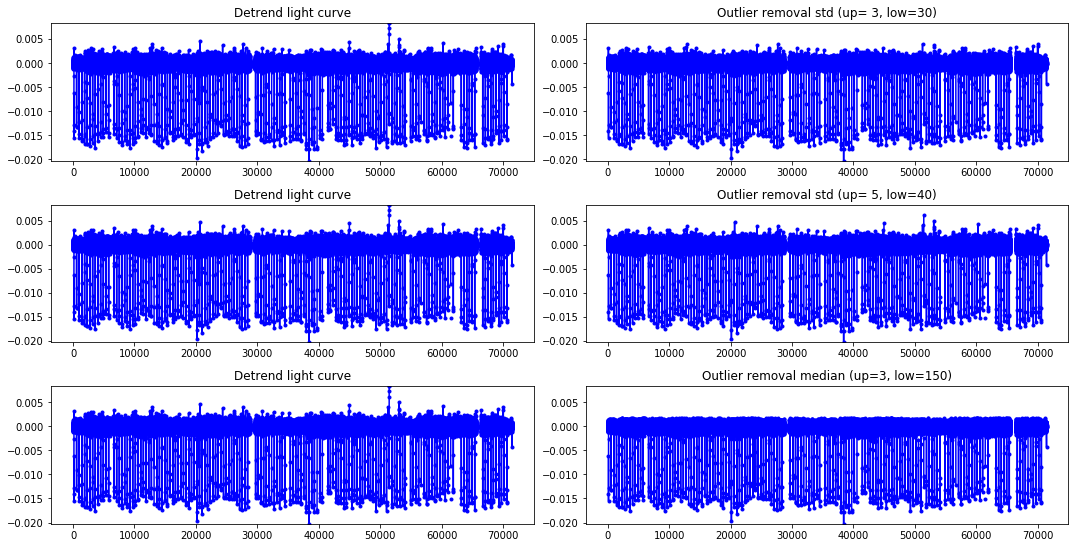

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 398 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 515 values


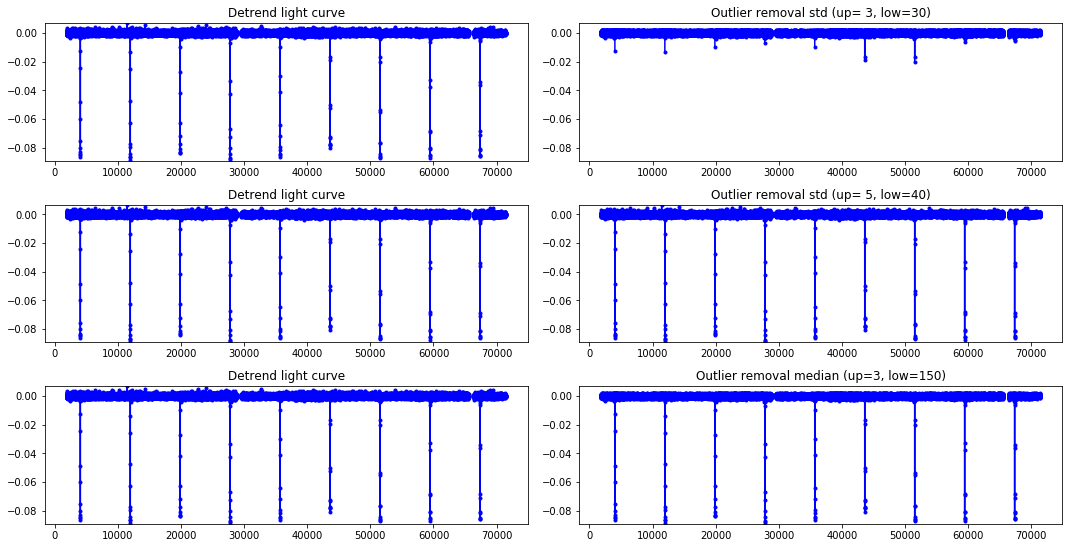

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 157 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 932 values


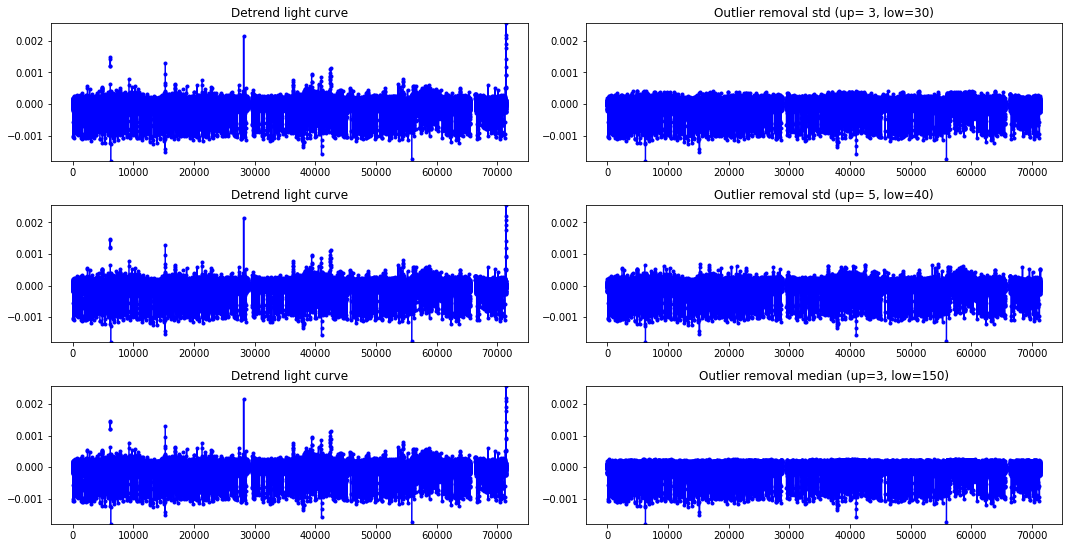

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 362 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 465 values


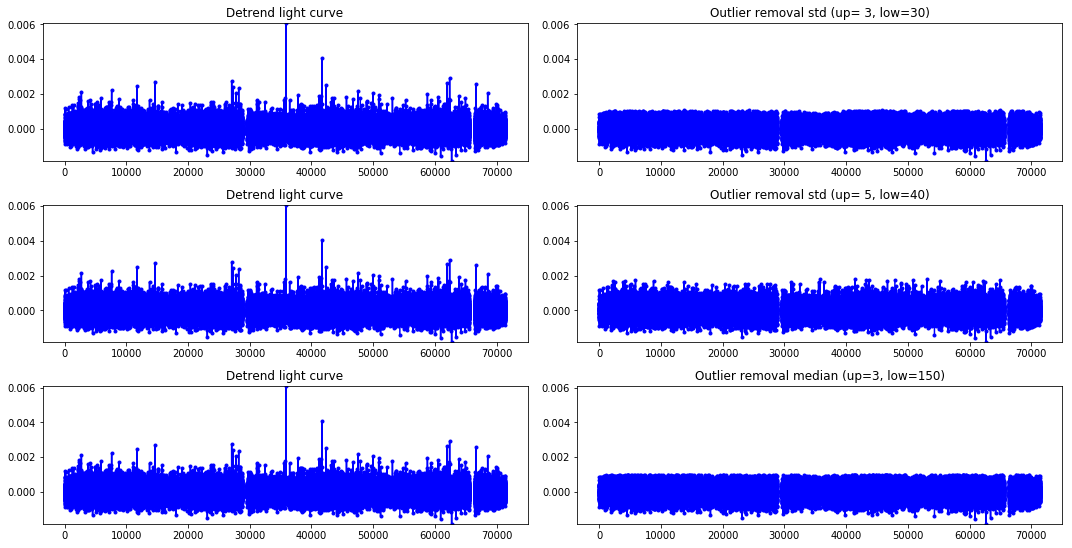

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 224 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 307 values


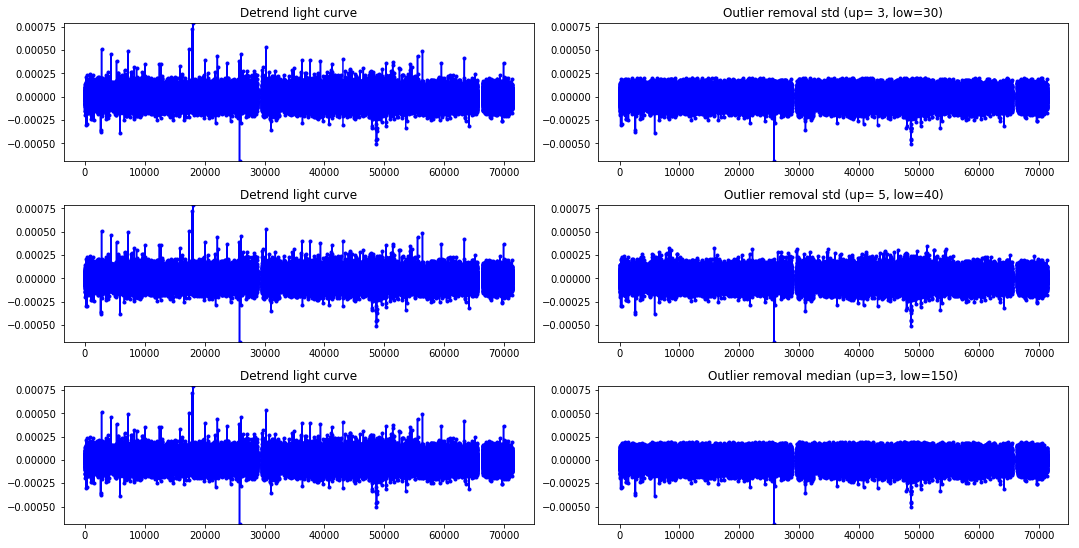

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 383 values
Clean done (remove outliers iterativetly), erase 53 values
Clean done (remove outliers iterativetly), erase 704 values


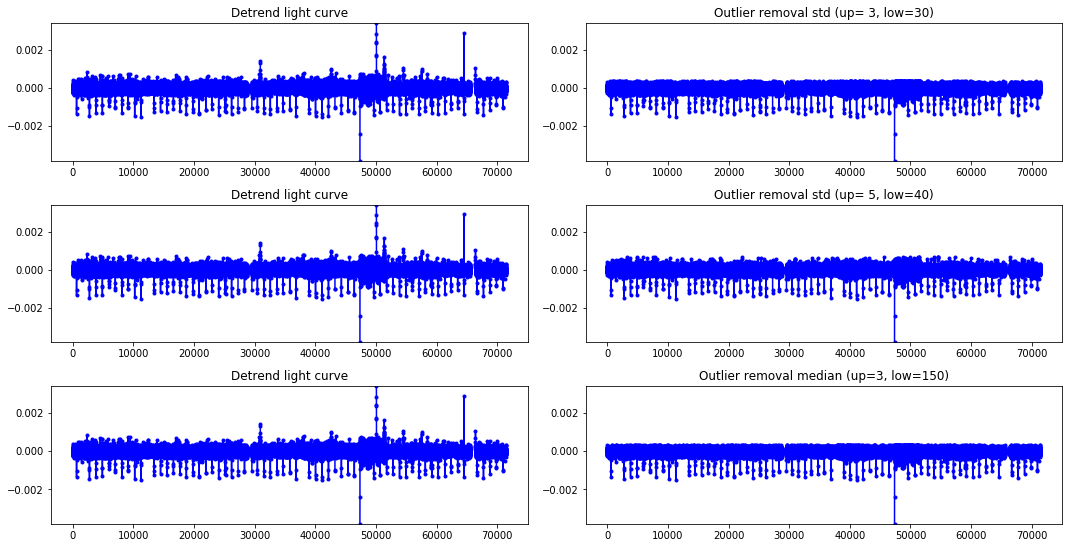

UNA CURVA DE LUZ
Clean done (remove outliers iterativetly), erase 273 values
Clean done (remove outliers iterativetly), erase 47 values
Clean done (remove outliers iterativetly), erase 319 values


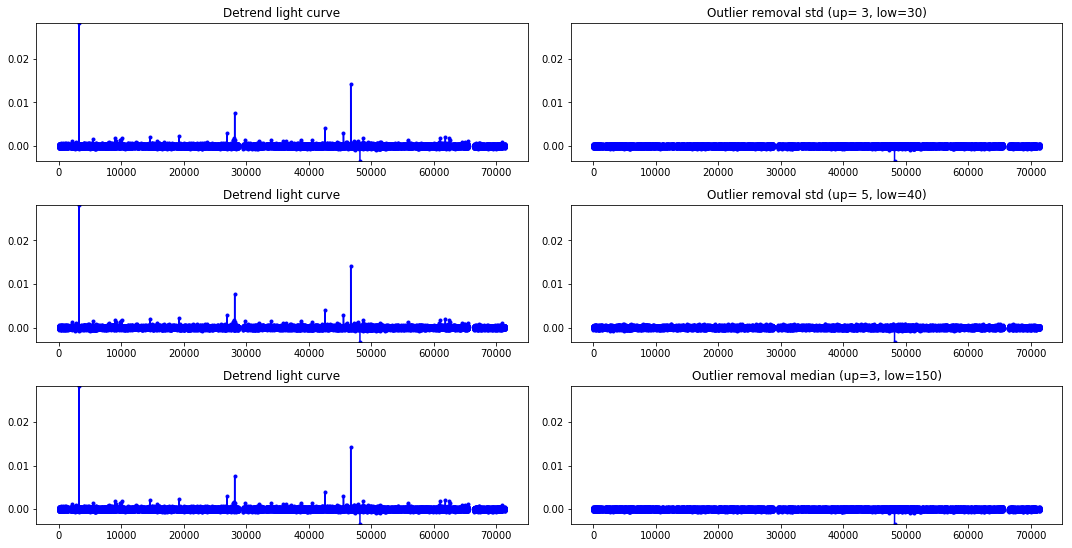

In [54]:
p_n = 1000
for i in range(len(fits_available)):
    print("UNA CURVA DE LUZ")
    hdulist = fits.open(folder+fits_available[i])
    data = hdulist[1].data
    lc_init = data.field("LC_INIT")
    
    final_lc = clean_LC(lc_init, kernel_median=25, kernel_pol=151, plot=False) 
    y0 = np.nanmin(final_lc)
    y1 = np.nanmax(final_lc)    
    plt.figure(figsize=(15,10))    
        
    plt.subplot(4, 2, 1)
    plt.plot(final_lc,'b.-')
    plt.title("Detrend light curve")
    plt.ylim(y0,y1)
    
    #outlier removal
    #lc_out_rm = remove_outliers(final_lc, 100,with_MAD=True)
    
    lc_out_rm = remove_outliers(final_lc, sigm_up = 3, sigm_low= 30, with_MAD=False) #o 5 sigma up
    plt.subplot(4, 2, 2)
    plt.plot(lc_out_rm,'b.-')
    plt.title("Outlier removal std (up= 3, low=30)")
    plt.ylim(y0,y1)
    
    plt.subplot(4, 2, 3)
    plt.plot(final_lc,'b.-')
    plt.title("Detrend light curve")
    plt.ylim(y0,y1)
    
    lc_out_rm = remove_outliers(final_lc, sigm_up = 5, sigm_low= 40, with_MAD=False)
    plt.subplot(4, 2, 4)
    plt.plot(lc_out_rm,'b.-')
    plt.title("Outlier removal std (up= 5, low=40)")
    plt.ylim(y0,y1)
    
    #
    plt.subplot(4, 2, 5)
    plt.plot(final_lc,'b.-')
    plt.title("Detrend light curve")
    plt.ylim(y0,y1)
    
    lc_out_rm = remove_outliers(final_lc, sigm_up = 3, sigm_low= 150, with_MAD=True)
    plt.subplot(4, 2, 6)
    plt.plot(lc_out_rm,'b.-')
    plt.title("Outlier removal median (up=3, low=150)")
    plt.ylim(y0,y1)
    
    plt.tight_layout()
    plt.show()